<a href="https://colab.research.google.com/github/Shakil-1501/AI/blob/master/Copy_of_main2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import copy

#from model1 import *

In [0]:
import cv2

In [3]:
from google.colab import files
files.upload()

Saving resnetmodel.py to resnetmodel.py


{'resnetmodel.py': b'# -*- coding: utf-8 -*-\n"""Resnetmodel.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1P34CLzYDzawkHCQdQ6egfZyA5-gpSQ7c\n"""\n\nimport torch\nimport torchvision\nimport torchvision.transforms as transforms\n\nimport torch.nn as nn\nimport torch.nn.functional as F\nclass BasicBlock(nn.Module):\n    expansion = 1\n\n    def __init__(self, in_planes, planes, stride=1):\n        super(BasicBlock, self).__init__()\n        self.conv1 = nn.Conv2d(\n            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)\n        self.bn1 = nn.BatchNorm2d(planes)\n        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,\n                               stride=1, padding=1, bias=False)\n        self.bn2 = nn.BatchNorm2d(planes)\n\n        self.shortcut = nn.Sequential()\n        if stride != 1 or in_planes != self.expansion*planes:\n            self.shortcut = nn.Sequential(\n   

In [4]:
from resnetmodel import *

cuda


In [5]:
from google.colab import files
files.upload()

Saving gradcamp.py to gradcamp.py


{'gradcamp.py': b'# -*- coding: utf-8 -*-\n"""gradcamp.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1LNyC72zkjBHUuJR1w_Exanb9Q1htalPf\n"""\n\nimport torch\nimport torch.nn.functional as F\n\nfrom statistics import mode, mean\n\n\nclass SaveValues():\n    def __init__(self, m):\n        # register a hook to save values of activations and gradients\n        self.activations = None\n        self.gradients = None\n        self.forward_hook = m.register_forward_hook(self.hook_fn_act)\n        self.backward_hook = m.register_backward_hook(self.hook_fn_grad)\n\n    def hook_fn_act(self, module, input, output):\n        self.activations = output\n\n    def hook_fn_grad(self, module, grad_input, grad_output):\n        self.gradients = grad_output[0]\n\n    def remove(self):\n        self.forward_hook.remove()\n        self.backward_hook.remove()\n\n\nclass CAM(object):\n    """ Class Activation Mapping """\n\n    d

In [0]:
from grad_cam import *

In [32]:
from google.colab import files
files.upload()

Saving gradcamp.py to gradcamp.py


{'gradcamp.py': b'# -*- coding: utf-8 -*-\n"""gradcamp.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1LNyC72zkjBHUuJR1w_Exanb9Q1htalPf\n"""\n\nimport torch\nimport torch.nn.functional as F\n\nfrom statistics import mode, mean\n\n\nclass SaveValues():\n    def __init__(self, m):\n        # register a hook to save values of activations and gradients\n        self.activations = None\n        self.gradients = None\n        self.forward_hook = m.register_forward_hook(self.hook_fn_act)\n        self.backward_hook = m.register_backward_hook(self.hook_fn_grad)\n\n    def hook_fn_act(self, module, input, output):\n        self.activations = output\n\n    def hook_fn_grad(self, module, grad_input, grad_output):\n        self.gradients = grad_output[0]\n\n    def remove(self):\n        self.forward_hook.remove()\n        self.backward_hook.remove()\n\n\nclass CAM(object):\n    """ Class Activation Mapping """\n\n    d

In [0]:
from gradcamp import *

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_transform = transforms.Compose( [transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomCrop(32, padding=2),
                                       #transforms.RandomErasing(),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1,hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=30,
                                          shuffle=True,num_workers=4, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=30,
                                         shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 bird   dog horse  bird


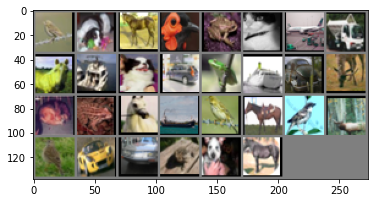

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
def save_gradient(filename, gradient):
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    cv2.imwrite(filename, np.uint8(gradient))


def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    cv2.imwrite(filename, np.uint8(gcam))


def save_sensitivity(filename, maps):
    maps = maps.cpu().numpy()
    scale = max(maps[maps > 0].max(), -maps[maps <= 0].min())
    maps = maps / scale * 0.5
    maps += 0.5
    maps = cm.bwr_r(maps)[..., :3]
    maps = np.uint8(maps * 255.0)
    maps = cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(filename, maps)


In [13]:
model_names = sorted(
    name
    for name in models.__dict__
    if name.islower() and not name.startswith("__") and callable(models.__dict__[name])
)




NameError: ignored

In [9]:

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
net = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay=0.001) # Applying L2 regularization
print(device)
#scheduler= StepLR(optimizer,step_size=5,gamma=0.1) # Applying LR schedular

cuda


In [10]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 900 == 899:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 899))
            running_loss = 0.0

print('Finished Training')

[1,   900] loss: 1.591
[2,   900] loss: 0.986
[3,   900] loss: 0.755
[4,   900] loss: 0.632
[5,   900] loss: 0.549
[6,   900] loss: 0.481
[7,   900] loss: 0.446
[8,   900] loss: 0.406
[9,   900] loss: 0.381
[10,   900] loss: 0.345
[11,   900] loss: 0.324
[12,   900] loss: 0.301
[13,   900] loss: 0.280
[14,   900] loss: 0.262
[15,   900] loss: 0.244
[16,   900] loss: 0.238
[17,   900] loss: 0.216
[18,   900] loss: 0.208
[19,   900] loss: 0.196
[20,   900] loss: 0.182
Finished Training


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %


In [12]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [0]:
target_layer = net.layer4[1].conv2

In [0]:
wrapped_model =GradCAM(net, target_layer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


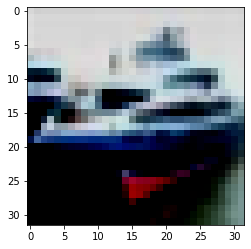

In [23]:
dataiter=iter(testloader)
images, labels = next(dataiter)
images=images.numpy()
image=np.transpose(images[1], (1, 2, 0))
plt.imshow(image)


In [0]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [29]:
images, labels = images.to(device), labels.to(device)

AttributeError: ignored

In [0]:
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [0]:
tensor=tensor.to(device)

In [31]:
cam, idx = wrapped_model(tensor)

predicted class ids 3	 probability 0.21995572745800018


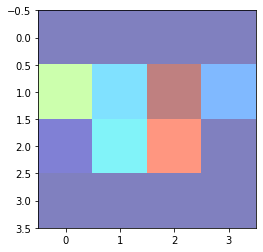

In [33]:
plt.imshow(cam.cpu().squeeze().numpy(), alpha=0.5, cmap='jet')

In [35]:
from google.colab import files
files.upload()

Saving utils.py to utils.py


{'utils.py': b'# -*- coding: utf-8 -*-\n"""utils.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1SxgR1BdgpjdDjlnLWO2awFWQk9TjtiIK\n"""\n\nimport torch\nimport torch.nn.functional as F\n\nimport numpy as np\nimport cv2\n\n\ndef reverse_normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):\n    x[:, 0, :, :] = x[:, 0, :, :] * std[0] + mean[0]\n    x[:, 1, :, :] = x[:, 1, :, :] * std[1] + mean[1]\n    x[:, 2, :, :] = x[:, 2, :, :] * std[2] + mean[2]\n    return x\n\n\ndef visualize(img, cam):\n    """\n    Synthesize an image with CAM to make a result image.\n    Args:\n        img: (Tensor) shape => (1, 3, H, W)\n        cam: (Tensor) shape => (1, 1, H\', W\')\n    Return:\n        synthesized image (Tensor): shape =>(1, 3, H, W)\n    """\n\n    _, _, H, W = img.shape\n    cam = F.interpolate(cam, size=(H, W), mode=\'bilinear\', align_corners=False)\n    cam = 255 * cam.squeeze()\n    heatmap = 

In [0]:
from utils import *
#from utils.imagenet_labels import label2idx, idx2label

In [0]:
img = reverse_normalize(tensor)

In [0]:
heatmap = visualize(img.cpu(), cam.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


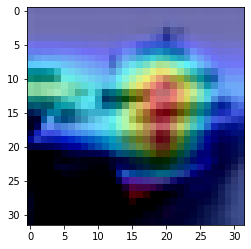

In [48]:
hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
plt.imshow(hm)

In [38]:

    cam, idx = wrapped_model(tensor)
#for data in testloader:
#        images, labels = data[0].to(device),data[1].to(device)


TypeError: ignored

In [9]:
@click.option("-i", "--image-paths", type=str, multiple=True, required=True)
@click.option("-o", "--output-dir", type=str, default="./results")
@click.option("--cuda/--cpu", default=True)

SyntaxError: ignored

In [0]:
def demo2(output_dir):
    """
    Generate Grad-CAM at different layers of ResNet-18
    """

    device= 'cuda' if torch.cuda.is_available() else 'cpu' 

    # Synset words
    #classes = get_classtable()

    # Model
    net = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
    #model = models.resnet152(pretrained=True)
    #model.to(device)
    net.eval()

    # The four residual layers
    target_layers = ["layer1", "layer2", "layer3", "layer4"]
    target_class = 10
      # "bull mastif"

    # Images
    #images, raw_images = load_images(image_paths)
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device),data[1].to(device)
    #images = torch.stack(images).to(device)

    gcam = GradCAM(model=net)
    probs, ids = gcam.forward(inputs)
    #ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    ids_ = torch.LongTensor([[target_class]] * len(inputs)).to(device)
    
    gcam.backward(ids=ids_)

    for target_layer in target_layers:
        print("Generating Grad-CAM @{}".format(target_layer))

        # Grad-CAM
        regions = gcam.generate(target_layer=target_layer)

        for j in range(len(inputs)):
            print(
                "\t#{}: {} ({:.5f})".format(
                    j, classes[target_class], float(probs[ids == target_class])
                )
            )

            save_gradcam(
                filename=osp.join(
                    output_dir,
                    "{}-{}-gradcam-{}-{}.png".format(
                        j, "resnet152", target_layer, classes[target_class]
                    ),
                ),
                gcam=regions[j, 0]
                #raw_image=raw_images[j],
            )

In [12]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
output_dir=F"/content/gdrive/My Drive/Colab Notebooks/Results"

In [30]:
demo2(output_dir)

Generating Grad-CAM @layer1


IndexError: ignored